<a href="https://colab.research.google.com/github/atfrank/CS-Annotate/blob/master/Structural_Annotation_of_RNA_Using_NMR_Chemical_Shifts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Structural Annotation of RNA Using NMR Chemical Shifts

# Initialization

In [1]:
%%capture
## Import Modules
import pandas as pd
import numpy as np
import io
import pandas as pd
import io
import requests
import deepchem as dc
import tensorflow as tf

In [2]:
DIR_PATH = 'data/'
NUMBER_CHEMICAL_SHIFT_TYPE = 19
RETAIN = ['id', 'resid', 'resname', 'sasa-All-atoms', 'sasa-Total-Side', 'sasa-Main-Chain', 'sasa-Non-polar', 'sasa-All', 'sasa', 'syn_anti', 'astack', 'nastack', 'pair', 'pucker', 'class']
RETAIN_NONAME = ['id', 'resid', 'sasa-All-atoms', 'sasa-Total-Side', 'sasa-Main-Chain', 'sasa-Non-polar', 'sasa-All', 'sasa', 'syn_anti', 'astack', 'nastack', 'pair', 'pucker', 'class']
from CSRNA import *

# Train Model

## Load data and preprocess

In [3]:
neighbors = 3
train = get_data(neighbors, training = True)
test = get_data(neighbors, training = False)
train_dataset, test_dataset, train_info, test_info, targets = process_data(train, test)

[INFO]: SASA loaded data
[INFO]: CS loaded data
[INFO]: MC-Annotate loaded data
[INFO]: merged SASA, CS, and MC-Annotate
[INFO]: Prepared final data set
[INFO]: One-hot encoded data
[INFO]: SASA loaded data
[INFO]: CS loaded data
[INFO]: MC-Annotate loaded data
[INFO]: merged SASA, CS, and MC-Annotate
[INFO]: Prepared final data set
[INFO]: One-hot encoded data


## Preprocess

In [4]:
# Scale Dataset
transform_scaler = dc.trans.transformers.NormalizationTransformer(transform_X = True, transform_y = False, dataset=train_dataset)
train_dataset_norm = transform_scaler.transform(train_dataset)
test_dataset_norm = transform_scaler.transform(test_dataset)

# Balance Dataset
transform_balancer = dc.trans.transformers.BalancingTransformer(transform_w = True, dataset=train_dataset_norm)
train_dataset_balanced = transform_balancer.transform(train_dataset_norm)

n_features = train_dataset_balanced.X.shape[1]
n_tasks = train_dataset_balanced.y.shape[1]

## Fit and Save Model

In [5]:
test_info

,id,resid,sasa
0,2JTP,1,203.92
1,2JTP,2,189.55
2,2JTP,3,191.87
3,2JTP,4,176.16
4,2JTP,5,185.36
...,...,...,...
125,5KH8,43,183.51
126,5KH8,44,180.49
127,5KH8,45,163.27
128,5KH8,46,188.07


In [9]:
%%capture
# suppress warning (confirm this is safe)
model = dc.models.ProgressiveMultitaskClassifier(n_tasks=n_tasks,n_features=n_features,
                                                 layer_sizes=[100],
                                                 alpha_init_stddevs=0.04,
                                                 learning_rate=0.001, 
                                                 model_dir='models/one-layer/', 
                                                 tensorboard=True, 
                                                 use_queue=False)

In [10]:
%%capture 
# suppress warning (confirm this is safe)
model.fit(train_dataset_balanced, nb_epoch=50)
model.get_checkpoints()

# Test Model

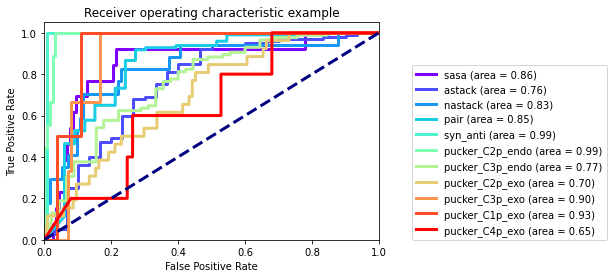

,id,resid,sasa,sasa,astack,nastack,pair,syn_anti,pucker_C2p_endo,pucker_C3p_endo,...,pastack,pnastack,ppair,psyn_anti,ppucker_C2p_endo,ppucker_C3p_endo,ppucker_C2p_exo,ppucker_C3p_exo,ppucker_C1p_exo,ppucker_C4p_exo
125,5KH8,43,183.51,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.999,0.000,0.152,0.0,0.027,0.929,0.002,0.0,0.0,0.892
126,5KH8,44,180.49,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.166,0.000,0.017,0.0,0.000,0.425,0.646,0.0,0.0,0.857
127,5KH8,45,163.27,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.524,0.000,1.000,0.0,0.000,1.000,0.000,0.0,0.0,0.921
128,5KH8,46,188.07,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.907,0.909,1.000,0.0,0.000,1.000,0.000,0.0,0.0,1.000
129,5KH8,47,338.68,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.010,0.000,1.000,0.0,0.000,1.000,0.000,0.0,0.0,1.000


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(targets)))
testpred = model.predict(test_dataset_norm)
actuals = pd.DataFrame.from_records(test_dataset_norm.y)
actuals.columns = targets

plt.figure()
lw = 3

# get TPR and FPR
for i,target in enumerate(targets):
  fpr, tpr, thresholds = roc_curve(test_dataset.y[:, i], testpred[:, i, 1].flatten())
  roc_auc = auc(fpr, tpr)
  # Make plot
  plt.plot(fpr, tpr, color=colors[i],lw=lw, label='%s (area = %0.2f)' % (target, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc=(1.1,0))
plt.show()

predictions = pd.DataFrame(testpred[:, :, 1], columns=["p"+i for i in targets])
predictions = pd.concat([test_info, actuals, predictions.round(3)], axis=1)
predictions.to_csv(DIR_PATH+'predictions.txt', sep = ' ')
predictions.tail()